# Informed search


## Code


Python code for Artificial Intelligence: Foundations of Computational Agents

David L. Poole and Alan K. Mackworth


In [ ]:
from __future__ import annotations

from abc import ABC, abstractmethod
from collections.abc import Iterator
from typing import Any

In [ ]:
class SearchProblem(ABC):
    """A search problem consists of:
    * a start node
    * a neighbors function that gives the neighbors of a node
    * a specification of a goal
    * a (optional) heuristic function.
    The methods must be overridden to define a search problem."""

    @abstractmethod
    def start_node(self) -> str | None:
        """returns start node"""

    @abstractmethod
    def is_goal(self, node: str) -> bool:
        """is True if node is a goal"""

    @abstractmethod
    def neighbors(self, node: str) -> list[Any]:
        """returns a list of the arcs for the neighbors of node"""

    def heuristic(self, node: str) -> int:
        """Gives the heuristic value of node n.
        Returns 0 if not overridden."""
        return 0

In [ ]:
class Arc:
    """An arc has a from_node and a to_node node and a (non-negative) cost"""

    def __init__(self, from_node: str, to_node: str, cost: int = 1, action: Any = None) -> None:
        assert cost >= 0, 'Cost cannot be negative for' + str(from_node) + '->' + str(to_node) + ', cost: ' + str(cost)
        self.from_node = from_node
        self.to_node = to_node
        self.action = action
        self.cost = cost

    def __repr__(self) -> str:
        """string representation of an arc"""
        if self.action:
            return str(self.from_node) + ' --' + str(self.action) + '--> ' + str(self.to_node)
        else:
            return str(self.from_node) + ' --> ' + str(self.to_node)

In [ ]:
class SearchProblemFromExplicitGraph(SearchProblem):
    """A search problem consists of:
    * a list or set of nodes
    * a list or set of arcs
    * a start node
    * a list or set of goal nodes
    * a dictionary that maps each node into its heuristic value.
    """

    def __init__(
        self,
        nodes: set[str],
        arcs: list[Arc],
        start: str | None = None,
        goals: set[str] | None = None,
        hmap: dict[str, int] | None = None,
    ) -> None:
        self.neighs: dict[str, list[Arc]] = {}
        self.nodes = nodes
        for node in nodes:
            self.neighs[node] = []
        self.arcs = arcs
        for arc in arcs:
            self.neighs[arc.from_node].append(arc)
        self.start = start
        self.goals = goals or set()
        self.hmap = hmap or {}

    def start_node(self) -> str | None:
        """returns start node"""
        return self.start

    def is_goal(self, node: str) -> bool:
        """is True if node is a goal"""
        return node in self.goals

    def neighbors(self, node: str) -> list[Arc]:
        """returns the neighbors of node"""
        return self.neighs[node]

    def heuristic(self, node: str) -> int:
        """Gives the heuristic value of node n.
        Returns 0 if not overridden in the hmap."""
        if node in self.hmap:
            return self.hmap[node]
        else:
            return 0

    def __repr__(self) -> str:
        """returns a string representation of the search problem"""
        res = ''
        for arc in self.arcs:
            res += str(arc) + '.  '
        return res

    def neighbor_nodes(self, node: str) -> Iterator[str]:
        """returns an iterator over the neighbors of node"""
        return (path.to_node for path in self.neighs[node])

In [ ]:
class Path:
    """A path is either a node or a path followed by an arc"""

    def __init__(self, initial: str | Path, arc: Arc | None = None) -> None:
        """initial is either a node (in which case arc is None) or
        a path (in which case arc is an object of type Arc)"""
        self.initial = initial
        self.arc = arc
        if arc is None:
            self.cost = 0
        else:
            self.cost = (initial.cost if isinstance(initial, Path) else 0) + arc.cost

    def end(self) -> str | Path:
        """returns the node at the end of the path"""
        if self.arc is None:
            return self.initial
        else:
            return self.arc.to_node

    def nodes(self) -> Iterator[str | Path]:
        """enumerates the nodes for the path.
        This starts at the end and enumerates nodes in the path backwards."""
        current = self
        while current.arc is not None:
            yield current.arc.to_node
            if isinstance(current.initial, Path):
                current = current.initial
        yield current.initial

    def initial_nodes(self) -> Iterator[str | Path]:
        """enumerates the nodes for the path before the end node.
        This starts at the end and enumerates nodes in the path backwards."""
        if self.arc is not None:
            if isinstance(self.initial, Path):
                yield from self.initial.nodes()

    def __repr__(self) -> str:
        """returns a string representation of a path"""
        if self.arc is None:
            return str(self.initial)
        elif self.arc.action:
            return str(self.initial) + '\n   --' + str(self.arc.action) + '--> ' + str(self.arc.to_node)
        else:
            return str(self.initial) + ' --> ' + str(self.arc.to_node)

In [ ]:
from typing import TypeVar

T = TypeVar('T')


class Displayable:
    """Class that uses 'display'.
    The amount of detail is controlled by max_display_level
    """

    max_display_level = 1  # can be overridden in subclasses

    def display(self, level: int, *args: Any, **nargs: Any) -> None:
        """print the arguments if level is less than or equal to the
        current max_display_level.
        level is an integer.
        the other arguments are whatever arguments print can take.
        """
        if level <= self.max_display_level:
            print(*args, **nargs)  # if error you are using Python2 not Python3


def visualize(func: T) -> T:
    """A decorator for algorithms that do interactive visualization.
    Ignored here.
    """
    return func

In [ ]:
# DFS
class Searcher(Displayable):
    """returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    This does depth-first search unless overridden
    """

    def __init__(self, problem: SearchProblem) -> None:
        """creates a searcher from a problem"""
        self.problem = problem
        self.initialize_frontier()
        self.num_expanded = 0
        self.add_to_frontier(Path(problem.start_node()))  # type: ignore
        super().__init__()

    def initialize_frontier(self) -> None:
        self.frontier: list[Path] = []

    def empty_frontier(self) -> bool:
        return self.frontier == []

    def add_to_frontier(self, path: Path) -> None:
        self.frontier.append(path)

    @visualize
    def search(self) -> Path | None:
        """returns (next) path from the problem's start node
        to a goal node.
        Returns None if no path exists.
        """
        while not self.empty_frontier():
            path = self.frontier.pop()
            self.display(2, 'Expanding:', path, '(cost:', path.cost, ')')
            self.num_expanded += 1
            if self.problem.is_goal(str(path.end())):  # solution found
                self.display(
                    1,
                    self.num_expanded,
                    'paths have been expanded and',
                    len(self.frontier),
                    'paths remain in the frontier',
                )
                self.solution = path  # store the solution found
                return path
            else:
                neighs = self.problem.neighbors(path.end())
                self.display(3, 'Neighbors are', neighs)
                for arc in reversed(neighs):
                    self.add_to_frontier(Path(path, arc))
                self.display(3, 'Frontier:', self.frontier)
        self.display(1, 'No (more) solutions. Total of', self.num_expanded, 'paths expanded.')
        return None

In [ ]:
import heapq  # part of the Python standard library


class FrontierPQ:
    """A frontier consists of a priority queue (heap), frontierpq, of
        (value, index, path) triples, where
    * value is the value we want to minimize (e.g., path cost + h).
    * index is a unique index for each element
    * path is the path on the queue
    Note that the priority queue always returns the smallest element.
    """

    def __init__(self) -> None:
        """constructs the frontier, initially an empty priority queue"""
        self.frontier_index = 0  # the number of items ever added to the frontier
        self.frontierpq = []  # the frontier priority queue

    def empty(self) -> bool:
        """is True if the priority queue is empty"""
        return self.frontierpq == []

    def add(self, path, value) -> None:
        """add a path to the priority queue
        value is the value to be minimized"""
        self.frontier_index += 1  # get a new unique index
        heapq.heappush(self.frontierpq, (value, -self.frontier_index, path))

    def pop(self):
        """returns and removes the path of the frontier with minimum value."""
        (_, _, path) = heapq.heappop(self.frontierpq)
        return path

    def count(self, val) -> int:
        """returns the number of elements of the frontier with value=val"""
        return sum(1 for e in self.frontierpq if e[0] == val)

    def __repr__(self) -> str:
        """string representation of the frontier"""
        return str([(n, c, str(p)) for (n, c, p) in self.frontierpq])

    def __len__(self) -> int:
        """length of the frontier"""
        return len(self.frontierpq)

    def __iter__(self):
        """iterate through the paths in the frontier"""
        for _, _, path in self.frontierpq:
            yield path

In [ ]:
class AStarSearcher(Searcher):
    """returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """

    def __init__(self, problem: SearchProblem) -> None:
        super().__init__(problem)

    def initialize_frontier(self) -> None:
        self.frontier: FrontierPQ = FrontierPQ()  # type: ignore

    def empty_frontier(self) -> bool:
        return self.frontier.empty()

    def add_to_frontier(self, path: Path) -> None:
        """add path to the frontier with the appropriate cost"""
        # print('path.end()', path.end(), type(path.end()))
        value = path.cost + self.problem.heuristic(path.end())
        self.frontier.add(path, value)

In [ ]:
problem1 = SearchProblemFromExplicitGraph(
    {'a', 'b', 'c', 'd', 'g'},
    [
        Arc('a', 'b', 1),
        Arc('a', 'c', 3),
        Arc('b', 'd', 3),
        Arc('b', 'c', 1),
        Arc('c', 'd', 1),
        Arc('c', 'g', 3),
        Arc('d', 'g', 1),
    ],
    start='a',
    goals={'g'},
)

In [ ]:
problem1

a --> b.  a --> c.  b --> d.  b --> c.  c --> d.  c --> g.  d --> g.  

In [ ]:
def test(SearchClass: type[Searcher]) -> None:
    print('Testing problem 1:')
    schr1 = SearchClass(problem1)
    path1 = schr1.search()
    print('Path found:', path1)
    print('Nodes in path:', list(path1.nodes()))
    assert list(path1.nodes()) == ['g', 'd', 'c', 'b', 'a'], 'Shortest path not found in problem1'
    print('Passed unit test')

In [ ]:
test(Searcher)

Testing problem 1:
4 paths have been expanded and 2 paths remain in the frontier
Path found: a --> b --> d --> g
Nodes in path: ['g', 'd', 'b', 'a']


AssertionError: Shortest path not found in problem1

In [ ]:
test(AStarSearcher)

Testing problem 1:
7 paths have been expanded and 4 paths remain in the frontier
Path found: a --> b --> c --> d --> g
Nodes in path: ['g', 'd', 'c', 'b', 'a']
Passed unit test


In [ ]:
problem2 = SearchProblemFromExplicitGraph(
    {'a', 'b', 'c', 'd', 'e', 'g', 'h', 'j'},
    [
        Arc('a', 'b', 1),
        Arc('b', 'c', 3),
        Arc('b', 'd', 1),
        Arc('d', 'e', 3),
        Arc('d', 'g', 1),
        Arc('a', 'h', 3),
        Arc('h', 'j', 1),
    ],
    start='a',
    goals={'g'},
)

In [ ]:
problem2

a --> b.  b --> c.  b --> d.  d --> e.  d --> g.  a --> h.  h --> j.  

In [ ]:
def test2(SearchClass: type[Searcher]) -> None:
    print('Testing problem 2:')
    schr2 = SearchClass(problem2)
    path2 = schr2.search()
    print('Path found:', path2)
    assert list(path2.nodes()) == ['g', 'd', 'b', 'a'], 'Shortest path not found in problem1'
    print('Passed unit test')

In [ ]:
test2(Searcher)

Testing problem 2:
6 paths have been expanded and 1 paths remain in the frontier
Path found: a --> b --> d --> g
Passed unit test


In [ ]:
test2(AStarSearcher)

Testing problem 2:
4 paths have been expanded and 3 paths remain in the frontier
Path found: a --> b --> d --> g
Passed unit test


## Problem 1


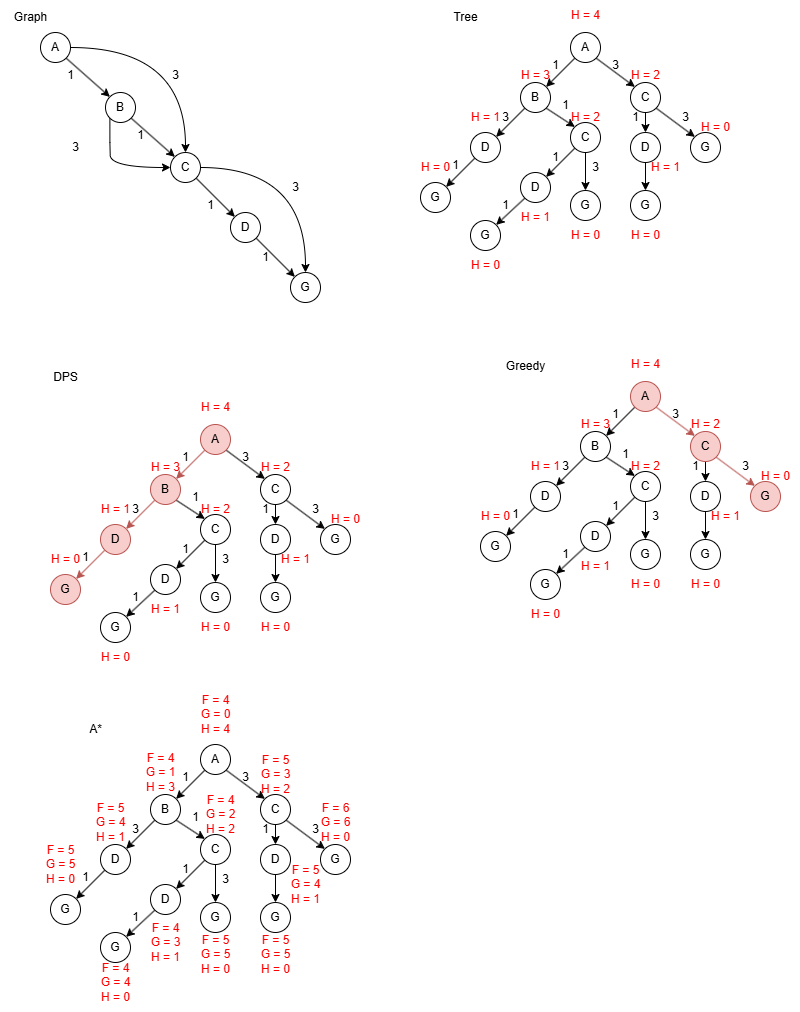

## Problem 2


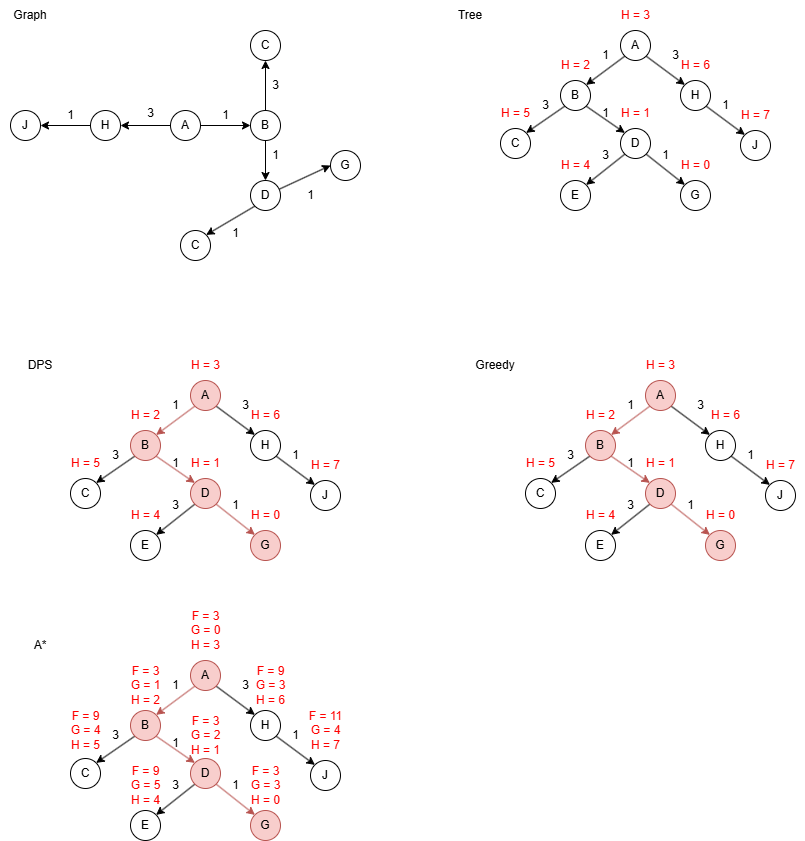